In [1]:
%pip install -q --upgrade torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121
%pip install -q "transformers==4.44.2" "datasets>=2.20.0" "evaluate==0.4.2" pandas matplotlib tqdm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.7/43.7 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.5/9.5 MB 114.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 123.8 MB/s eta 0:00:00


In [2]:
from google.colab import drive
drive.mount('/content/drive')

DATA_DIR  = "/content/drive/MyDrive/DL4H_data/mimic"
CKPT_DIR  = "/content/drive/MyDrive/DL4H_data/ckpt"
LOGS_DIR  = "/content/drive/MyDrive/DL4H_data/logs"
FIGS_DIR  = "/content/drive/MyDrive/DL4H_data/figs"

import os
for p in [DATA_DIR, CKPT_DIR, LOGS_DIR, FIGS_DIR]:
    os.makedirs(p, exist_ok=True)

Mounted at /content/drive


In [4]:
import os
os.environ["HF_HOME"] = "/content/drive/MyDrive/DL4H_data/hf_cache"
os.makedirs(os.environ["HF_HOME"], exist_ok=True)

In [5]:
from datasets import load_dataset
import pandas as pd
import numpy as np

ds = load_dataset("itsanmolgupta/mimic-cxr-dataset")
print(ds)

df = pd.DataFrame({
    "report_id": np.arange(len(ds["train"])),
    "findings": ds["train"]["findings"],
    "impression": ds["train"]["impression"],
})
df["report_text"] = (
    df["impression"].fillna("").astype(str).str.strip() + " " +
    df["findings"].fillna("").astype(str).str.strip()
).str.strip()

# drop empty reports
df = df[df["report_text"].str.len() > 0].reset_index(drop=True)
print("Reports after filtering:", len(df))
df.head(3)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/357 [00:00<?, ?B/s]

data/train-00000-of-00002.parquet:   0%|          | 0.00/396M [00:00<?, ?B/s]

data/train-00001-of-00002.parquet:   0%|          | 0.00/397M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/30633 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['image', 'findings', 'impression'],
        num_rows: 30633
    })
})
Reports after filtering: 30633


,report_id,findings,impression,report_text
0,0,"The lungs are clear of focal consolidation, pl...",No acute cardiopulmonary process.,No acute cardiopulmonary process. The lungs ar...
1,1,Lung volumes remain low. There are innumerable...,Low lung volumes and mild pulmonary vascular c...,Low lung volumes and mild pulmonary vascular c...
2,2,Lung volumes are low. This results in crowding...,Innumerable pulmonary metastases. Possible mil...,Innumerable pulmonary metastases. Possible mil...


In [6]:
rng = np.random.default_rng(42)
perm = rng.permutation(len(df))
n = len(df)
i_tr = int(0.8*n); i_va = int(0.9*n)

df["split"] = "test"
df.loc[perm[:i_tr], "split"] = "train"
df.loc[perm[i_tr:i_va], "split"] = "val"

df["split"].value_counts()

,count
split,
train,24506
test,3064
val,3063


In [7]:
import re
from tqdm import tqdm

def sent_tokenize(text: str):
    parts = re.split(r'(?<=[\.\?\!])\s+|\n+', text)
    return [s.strip() for s in parts if s and s.strip()]

ABN_TERMS = [
    "pneumonia","consolidation","edema","effusion","atelectasis","pneumothorax",
    "fracture","opacity","lesion","mass","enlarged","cardiomegaly","infiltrate",
    "hemorrhage","emphysema","fibrosis","collapse","airspace","air-fluid","pleural",
    "mediastinal widening","hyperinflation","interstitial","ground-glass"
]
NORM_PHRASES = [
    "no acute cardiopulmonary process","no acute cardiopulmonary disease",
    "no acute process","no acute abnormality","no acute findings","no focal consolidation",
    "no pleural effusion","no pneumothorax","heart size is normal","lungs are clear",
    "no acute osseous abnormality"
]
UNCERTAIN_MARKERS = [
    "cannot exclude","question of","possible","may represent","suggest","probable",
    "likely","suspicious for"," ?"," ? "
]

abn_re  = re.compile(r"\b(" + "|".join(re.escape(w) for w in ABN_TERMS) + r")\b", re.I)
norm_re = re.compile("|".join(re.escape(p) for p in NORM_PHRASES), re.I)
unc_re  = re.compile("|".join(re.escape(p) for p in UNCERTAIN_MARKERS), re.I)

def weak_label(s: str) -> str:
    s = s.strip()
    if not s:
        return "uncertain"
    has_abn  = bool(abn_re.search(s))
    has_norm = bool(norm_re.search(s))
    has_unc  = bool(unc_re.search(s))
    if has_abn: return "abnormal"
    if has_norm and not has_abn: return "normal"
    return "uncertain"

In [8]:
rows = []
for idx, r in tqdm(df.iterrows(), total=len(df)):
    sents = sent_tokenize(r["report_text"])
    for j, sent in enumerate(sents):
        if len(sent) < 3:
            continue
        rows.append({
            "report_id": int(r["report_id"]),
            "sentence_id": j,
            "text": sent,
            "label": weak_label(sent),
            "split": r["split"],
        })

sent_df = pd.DataFrame(rows)
print("Total sentences:", len(sent_df))
sent_df.head(5)

100%|██████████| 30633/30633 [00:09<00:00, 3238.64it/s]


Total sentences: 230355


,report_id,sentence_id,text,label,split
0,0,0,No acute cardiopulmonary process.,normal,train
1,0,1,"The lungs are clear of focal consolidation, pl...",abnormal,train
2,0,2,The heart size is normal.,normal,train
3,0,3,The mediastinal contours are normal.,uncertain,train
4,0,4,Multiple surgical clips project over the left ...,uncertain,train


In [9]:
def dist(df):
    return df["label"].value_counts(normalize=True).round(3).to_dict()

print("ALL:", dist(sent_df))
for sp in ["train","val","test"]:
    print(sp, dist(sent_df[sent_df["split"]==sp]))

ALL: {'uncertain': 0.517, 'abnormal': 0.455, 'normal': 0.028}
train {'uncertain': 0.517, 'abnormal': 0.456, 'normal': 0.028}
val {'uncertain': 0.522, 'abnormal': 0.45, 'normal': 0.028}
test {'uncertain': 0.518, 'abnormal': 0.453, 'normal': 0.028}


In [10]:
import os
for split in ["train","val","test"]:
    out = (sent_df[sent_df["split"]==split]
           [["report_id","sentence_id","text","label"]]
           .reset_index(drop=True))
    out_path = f"{DATA_DIR}/{split}.csv"
    out.to_csv(out_path, index=False)
    print(split, len(out), "->", out_path)

import pandas as pd
for split in ["train","val","test"]:
    path = f"{DATA_DIR}/{split}.csv"
    df_split = pd.read_csv(path)
    df_split.sample(n=min(1000, len(df_split)), random_state=1).to_csv(
        f"{DATA_DIR}/{split}_mini.csv", index=False
    )
print("Wrote mini splits.")

train 183888 -> /content/drive/MyDrive/DL4H_data/mimic/train.csv
val 23232 -> /content/drive/MyDrive/DL4H_data/mimic/val.csv
test 23235 -> /content/drive/MyDrive/DL4H_data/mimic/test.csv
Wrote mini splits.


In [11]:
import pandas as pd

def label_dist(path):
    df = pd.read_csv(path)
    return {"rows": len(df), "dist": df["label"].value_counts(normalize=True).round(3).to_dict()}

print({
    "source": "HF itsanmolgupta/mimic-cxr-dataset + weak sentence labels (rule-based)",
    "train": label_dist(f"{DATA_DIR}/train.csv"),
    "val":   label_dist(f"{DATA_DIR}/val.csv"),
    "test":  label_dist(f"{DATA_DIR}/test.csv"),
})

{'source': 'HF itsanmolgupta/mimic-cxr-dataset + weak sentence labels (rule-based)', 'train': {'rows': 183888, 'dist': {'uncertain': 0.517, 'abnormal': 0.456, 'normal': 0.028}}, 'val': {'rows': 23232, 'dist': {'uncertain': 0.522, 'abnormal': 0.45, 'normal': 0.028}}, 'test': {'rows': 23235, 'dist': {'uncertain': 0.518, 'abnormal': 0.453, 'normal': 0.028}}}


In [12]:
import torch, platform
print("CUDA:", torch.cuda.is_available())
if torch.cuda.is_available(): print("GPU:", torch.cuda.get_device_name(0))
import transformers, datasets, evaluate
print("transformers:", transformers.__version__)
print("datasets:", datasets.__version__)
print("evaluate:", evaluate.__version__)
print("Python:", platform.python_version())
print("CSV sizes:",
      {s: sum(1 for _ in open(f"{DATA_DIR}/{s}.csv"))-1 for s in ["train","val","test"]})

CUDA: True
GPU: Tesla T4
transformers: 4.44.2
datasets: 4.0.0
evaluate: 0.4.2
Python: 3.12.12
CSV sizes: {'train': 183888, 'val': 23232, 'test': 23235}


In [13]:
# --- config ---
LABELS = ["normal","abnormal","uncertain"]
label2id = {l:i for i,l in enumerate(LABELS)}
id2label = {i:l for l,i in label2id.items()}
MODEL_NAME = "emilyalsentzer/Bio_ClinicalBERT"
MAX_LEN = 128
BATCH_TRAIN = 32
BATCH_EVAL  = 64
LR = 2e-5
EPOCHS = 3
SEED = 42

In [14]:
import pandas as pd, os
def need(path):
    assert os.path.exists(path), f"Missing {path}"
    df = pd.read_csv(path)
    req = {"report_id","sentence_id","text","label"}
    assert req.issubset(df.columns), f"{path} must have columns {req}"
    return df

train_df = need(f"{DATA_DIR}/train.csv")
val_df   = need(f"{DATA_DIR}/val.csv")
test_df  = need(f"{DATA_DIR}/test.csv")

for d in (train_df, val_df, test_df):
    d["labels"] = d["label"].map(label2id)

In [15]:
from datasets import Dataset
from transformers import AutoTokenizer
tok = AutoTokenizer.from_pretrained(MODEL_NAME)

def to_ds(df): return Dataset.from_pandas(df[["text","labels"]].reset_index(drop=True))
train_ds, val_ds, test_ds = map(to_ds, [train_df, val_df, test_df])

def tokenize(batch):
    return tok(batch["text"], padding="max_length", truncation=True, max_length=MAX_LEN)

train_tok = train_ds.map(tokenize, batched=True).with_format("torch", columns=["input_ids","attention_mask","labels"])
val_tok   = val_ds.map(tokenize,   batched=True).with_format("torch", columns=["input_ids","attention_mask","labels"])
test_tok  = test_ds.map(tokenize,  batched=True).with_format("torch", columns=["input_ids","attention_mask","labels"])

config.json:   0%|          | 0.00/385 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

/usr/local/lib/python3.12/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Map:   0%|          | 0/183888 [00:00<?, ? examples/s]

Map:   0%|          | 0/23232 [00:00<?, ? examples/s]

Map:   0%|          | 0/23235 [00:00<?, ? examples/s]

In [16]:
import numpy as np, evaluate
metric_acc = evaluate.load("accuracy")
metric_f1  = evaluate.load("f1")
metric_auc = evaluate.load("roc_auc","multiclass")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    out = {
        "accuracy": metric_acc.compute(predictions=preds, references=labels)["accuracy"],
        "f1_macro": metric_f1.compute(predictions=preds, references=labels, average="macro")["f1"],
    }
    try:
        out["auc_ovr"] = metric_auc.compute(
            prediction_scores=logits, references=labels, multi_class="ovr", average="macro"
        )["roc_auc"]
    except Exception:
        pass
    return out

In [19]:
import torch, numpy as np, time, json
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer, set_seed
import os
set_seed(SEED)

model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME, num_labels=3, id2label=id2label, label2id=label2id
)

y = train_df["labels"].to_numpy()
counts = np.bincount(y, minlength=3)
w = (1.0 / (counts + 1e-6)); w = w / w.sum() * 3.0
class_weights = torch.tensor(w, dtype=torch.float32).to("cuda" if torch.cuda.is_available() else "cpu")
print("class weights [normal, abnormal, uncertain]:", class_weights.tolist())

class WeightedTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.get("labels")
        outputs = model(**inputs); logits = outputs.get("logits")
        loss = torch.nn.functional.cross_entropy(logits, labels, weight=class_weights)
        return (loss, outputs) if return_outputs else loss

run_name = f"baseline_ce_{MODEL_NAME.split('/')[-1]}_{int(time.time())}"
out_dir  = f"{CKPT_DIR}/{run_name}"
os.makedirs(out_dir, exist_ok=True)

args = TrainingArguments(
    output_dir=out_dir,
    per_device_train_batch_size=BATCH_TRAIN,
    per_device_eval_batch_size=BATCH_EVAL,
    num_train_epochs=EPOCHS,
    learning_rate=LR,
    weight_decay=0.01,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="f1_macro",
    greater_is_better=True,
    seed=SEED,
    fp16=True if torch.cuda.is_available() else False,
    logging_steps=50,
    report_to="none",
    save_safetensors=False,
    overwrite_output_dir=True,
)

trainer = WeightedTrainer(
    model=model,
    args=args,
    train_dataset=train_tok,
    eval_dataset=val_tok,
    compute_metrics=compute_metrics,
)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at emilyalsentzer/Bio_ClinicalBERT and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


class weights [normal, abnormal, uncertain]: [2.6912715435028076, 0.1640545129776001, 0.14467404782772064]


In [20]:
train_out = trainer.train()
test_metrics = trainer.evaluate(test_tok)
test_metrics

Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro
1,0.011800,0.006414,0.999785,0.999370
2,0.000000,0.007363,0.999699,0.999072
3,0.000000,0.007806,0.999871,0.999669


{'eval_loss': 0.0002951101341750473,
 'eval_accuracy': 0.9999139229610502,
 'eval_f1_macro': 0.9997037838408898,
 'eval_runtime': 41.2128,
 'eval_samples_per_second': 563.781,
 'eval_steps_per_second': 8.832,
 'epoch': 3.0}

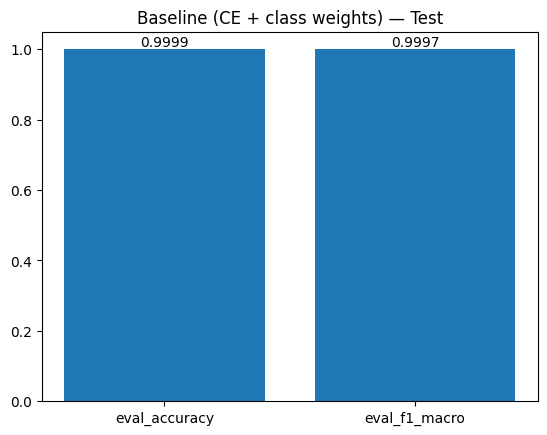

{'out_dir': '/content/drive/MyDrive/DL4H_data/ckpt/baseline_ce_Bio_ClinicalBERT_1763057639',
 'fig': '/content/drive/MyDrive/DL4H_data/figs/baseline_ce_Bio_ClinicalBERT_1763057639_metrics.png'}

In [22]:
import os, json, pandas as pd, matplotlib.pyplot as plt

os.makedirs(FIGS_DIR, exist_ok=True)

with open(os.path.join(out_dir, "test_metrics.json"), "w") as f:
    json.dump(test_metrics, f, indent=2)
pd.DataFrame([test_metrics]).to_csv(os.path.join(out_dir, "test_metrics.csv"), index=False)

keys = [k for k in ["eval_accuracy","eval_f1_macro"] if k in test_metrics]
vals = [test_metrics[k] for k in keys]
plt.figure(); plt.bar(keys, vals)
for i,v in enumerate(vals): plt.text(i, v, f"{v:.4f}", ha="center", va="bottom")
plt.title("Baseline (CE + class weights) — Test")
fig_path = os.path.join(FIGS_DIR, f"{os.path.basename(out_dir)}_metrics.png")
plt.savefig(fig_path, bbox_inches="tight"); plt.show()

{"out_dir": out_dir, "fig": fig_path}

In [23]:
import numpy as np, pandas as pd
from sklearn.metrics import classification_report, confusion_matrix

preds = trainer.predict(test_tok)
y_true = preds.label_ids
y_pred = np.argmax(preds.predictions, axis=-1)

LABELS = ["normal","abnormal","uncertain"]
print(classification_report(y_true, y_pred, target_names=LABELS, digits=3))

cm = confusion_matrix(y_true, y_pred, labels=range(len(LABELS)))
cm_df = pd.DataFrame(cm, index=[f"true_{l}" for l in LABELS],
                         columns=[f"pred_{l}" for l in LABELS])
cm_df

              precision    recall  f1-score   support

      normal      0.998     1.000     0.999       659
    abnormal      1.000     1.000     1.000     10529
   uncertain      1.000     1.000     1.000     12047

    accuracy                          1.000     23235
   macro avg      0.999     1.000     1.000     23235
weighted avg      1.000     1.000     1.000     23235



,pred_normal,pred_abnormal,pred_uncertain
true_normal,659,0,0
true_abnormal,0,10528,1
true_uncertain,1,0,12046


In [ ]:
#!/usr/bin/env python3
import nbformat
from pathlib import Path

for path in Path(".").rglob("*.ipynb"):
    nb = nbformat.read(path, as_version=4)
    meta = nb.get("metadata", {})
    if "widgets" in meta:
        print(f"Stripping widgets metadata from {path}")
        del meta["widgets"]
        nb["metadata"] = meta
        nbformat.write(nb, path)